# Importing libraries

In [2]:
import pandas as pd
import tensorflow as tf
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting images and masks

There are 60 images with 4 classes.

Masks have $0$ in pixels with background and Label $[1,2,3,4]$ in their channels depending on class.

In [324]:
import os
import numpy as np
# there are 60 images but with augmentation will be 240
images = np.empty(shape=(240, 128, 128, 3))
masks = np.empty(shape=(240, 128, 128, 1), dtype=np.int8)
# get image directories
image_path, masks_path = '/content/drive/My Drive/Segmentation/img/', '/content/drive/My Drive/Segmentation/masks_machine/'
counter = 0
# load images to numpy arrays
for image_name, mask_name in zip(sorted(os.listdir(image_path)), sorted(os.listdir(masks_path))):

  # inverting order of colors because tensorflow assumes BGR
  images[counter] = cv2.resize(cv2.cvtColor(cv2.imread(image_path + image_name), cv2.COLOR_RGB2BGR), (128, 128))

  # collapse masks into 1 channel beacuse all 3 are the same
  masks[counter] = np.expand_dims(cv2.resize(cv2.imread(masks_path + mask_name)[:,:,0], (128, 128)), axis=2)

  counter += 1

# Visualize an example



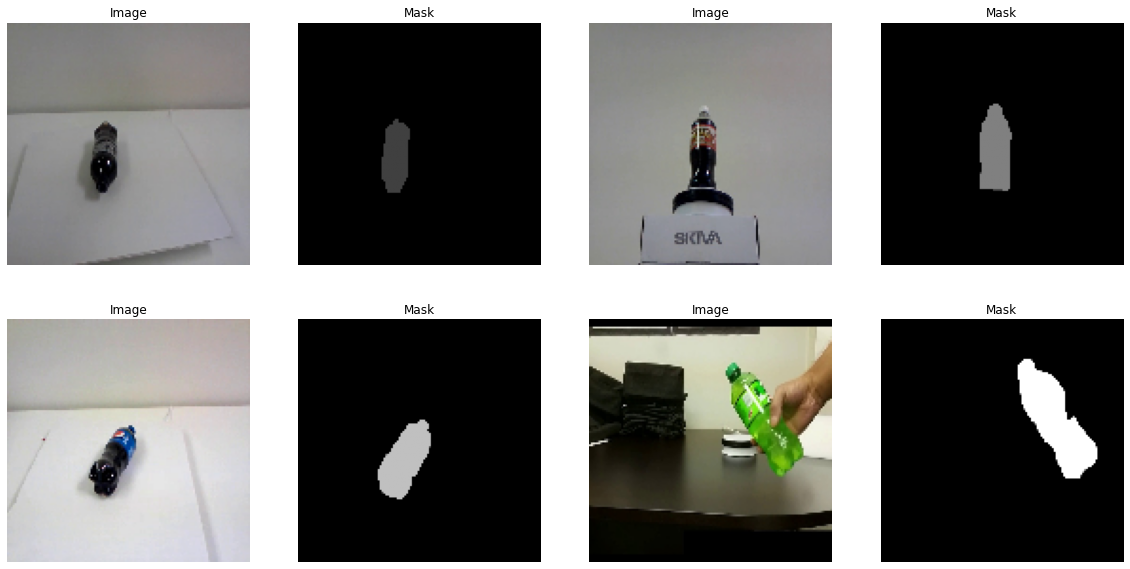

In [325]:
import matplotlib.pyplot as plt
# display image and mask
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(2):
  for j in range(2):
    axs[i][2*j].set_title('Image')
    axs[i][2*j+1].set_title('Mask')
    axs[i][j].axis('off')
    axs[i][j+2].axis('off')

# labels go from 1 in upper left to 4 in lower right. Each is multiplied by 0.25 to get different shade of gray
axs[0][0].imshow(tf.keras.preprocessing.image.array_to_img(images[2]))
axs[0][1].imshow(np.squeeze(masks[2], axis=2)*0.25, cmap='gray', vmin=0, vmax=1)
axs[0][2].imshow(tf.keras.preprocessing.image.array_to_img(images[23]))
axs[0][3].imshow(np.squeeze(masks[23], axis=2)*0.25, cmap='gray', vmin=0, vmax=1)

axs[1][0].imshow(tf.keras.preprocessing.image.array_to_img(images[10]))
axs[1][1].imshow(np.squeeze(masks[10], axis=2)*0.25, cmap='gray', vmin=0, vmax=1)
axs[1][2].imshow(tf.keras.preprocessing.image.array_to_img(images[33]))
axs[1][3].imshow(np.squeeze(masks[33], axis=2)*0.25, cmap='gray', vmin=0, vmax=1)

plt.show()

# Augmenting and Spliting data

Images, and their respective masks, will be rotated 90, 180 and 270 degrees getting us 4 images in place of 1.

Only train and test are used because of a small datasize.

In [326]:
# add rotated images and masks
for k in range(3):
  aug_img = tf.image.rot90(images, k)
  aug_msk = tf.image.rot90(masks, k)
  for i in range(60):
    images[counter] = aug_img[i]
    masks[counter] = aug_msk[i]
    counter += 1

In [426]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

img_train, img_test, mask_train, mask_test = train_test_split(images, masks, train_size=0.8)

# because each image has a lot more background then foreground we need to give weights to classes
weights = class_weight.compute_class_weight('balanced', np.unique(mask_train), mask_train.flatten())
# double it because we only care about foreground
weights[1:] += weights[1:]

# assign each pixel the weight for it's class
sample_weights = weights[mask_train]

# one hot encode masks
# mask_train = np.squeeze(np.eye(5)[mask_train], axis=3)
# mask_test = np.squeeze(np.eye(5)[mask_test], axis=3)

# convert everything to tensorflow tensor
for d in [img_train, img_test, mask_train, mask_test]:
  d = tf.convert_to_tensor(d)

# Defining and training model

I'm going to be using modified U-Net architecture. It consists of encoder (downsampler, which will be parts of a pretrained MobileNetV2) and decoder (upsampler which will be custom).

https://www.tensorflow.org/tutorials/images/segmentation

https://www.tensorflow.org/tutorials/generative/pix2pix

In [427]:
# https://arxiv.org/abs/1801.04381
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)
# scaling pixel values to [-1,1]
preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input

In [428]:
# layers from base_model used in encoder
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# don't train it
down_stack.trainable = False

In [429]:
def upsample(filters, size):
  """Defining decoder"""
  result = tf.keras.Sequential()
  # basically uses input and kernel to produce feature map of bigger dimensions
  # https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
  # standardizing activations
  result.add(tf.keras.layers.BatchNormalization())
  # reducing overfitting
  result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

In [430]:
up_stack = [
    upsample(512, 4),  # 4x4 -> 8x8
    upsample(256, 4),  # 8x8 -> 16x16
    upsample(128, 4),  # 16x16 -> 32x32
    upsample(64, 4),   # 32x32 -> 64x64
]
output_layer = tf.keras.layers.Conv2DTranspose(5, 2, strides=2, padding='same', use_bias=False)  # 64x64 -> 128x128

inputs = tf.keras.layers.Input(shape=(128, 128, 3))

x = preprocess_layer(inputs)

# add downsampling
skips = down_stack(inputs)
x = skips[-1]
# use skip connections to preserve some details
skips = reversed(skips[:-1])

# add upsampling
for up, skip in zip(up_stack, skips):
    x = up(x)
    # connect two layers
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

x = output_layer(x)

# get it all together
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_68 (Functional)           [(None, 64, 64, 96), 1841984     input_74[0][0]                   
__________________________________________________________________________________________________
sequential_193 (Sequential)     (None, 8, 8, 512)    2623488     model_68[0][4]                   
__________________________________________________________________________________________________
concatenate_184 (Concatenate)   (None, 8, 8, 1088)   0           sequential_193[0][0]             
                                                                 model_68[0][3]            

In [449]:
# using Sparse Categorical Crossentropy; using integers as classes, without one hot encoding
# using logits means that output values are not normalized
# https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# using sample_weight to give more importance to foreground pixels and less to background
model.fit(img_train, mask_train, batch_size=12, epochs=20, sample_weight=sample_weights)

model.evaluate(img_test, mask_test)

Epoch 1/20
16/16 [==============================] - 6s 116ms/step - loss: 0.2438 - accuracy: 0.9161
Epoch 2/20
16/16 [==============================] - 2s 115ms/step - loss: 0.2382 - accuracy: 0.9199
Epoch 3/20
16/16 [==============================] - 2s 116ms/step - loss: 0.2493 - accuracy: 0.9230
Epoch 4/20
16/16 [==============================] - 2s 116ms/step - loss: 0.2332 - accuracy: 0.9222
Epoch 5/20
16/16 [==============================] - 2s 116ms/step - loss: 0.2009 - accuracy: 0.9232
Epoch 6/20
16/16 [==============================] - 2s 116ms/step - loss: 0.2049 - accuracy: 0.9259
Epoch 7/20
16/16 [==============================] - 2s 115ms/step - loss: 0.2111 - accuracy: 0.9274
Epoch 8/20
16/16 [==============================] - 2s 116ms/step - loss: 0.2017 - accuracy: 0.9290
Epoch 9/20
16/16 [==============================] - 2s 116ms/step - loss: 0.1941 - accuracy: 0.9305
Epoch 10/20
16/16 [==============================] - 2s 116ms/step - loss: 0.1873 - accuracy: 0.9331

[0.17402218282222748, 0.9513689875602722]

# Visualize predictions

In [438]:
def get_predicted_mask(img):
  # image expanded at axis 0 to (1, 128, 128, 3)
  img = np.expand_dims(img, axis=(0))
  # get prediction which has dims (1, 128, 128, 5)
  pred = model.predict(img)
  # shave of the first dimension
  pred = np.squeeze(pred, axis=0)
  # get the predicted class from one hot ecoded array
  mask = np.argmax(pred, axis=2)
  # return mask
  return mask

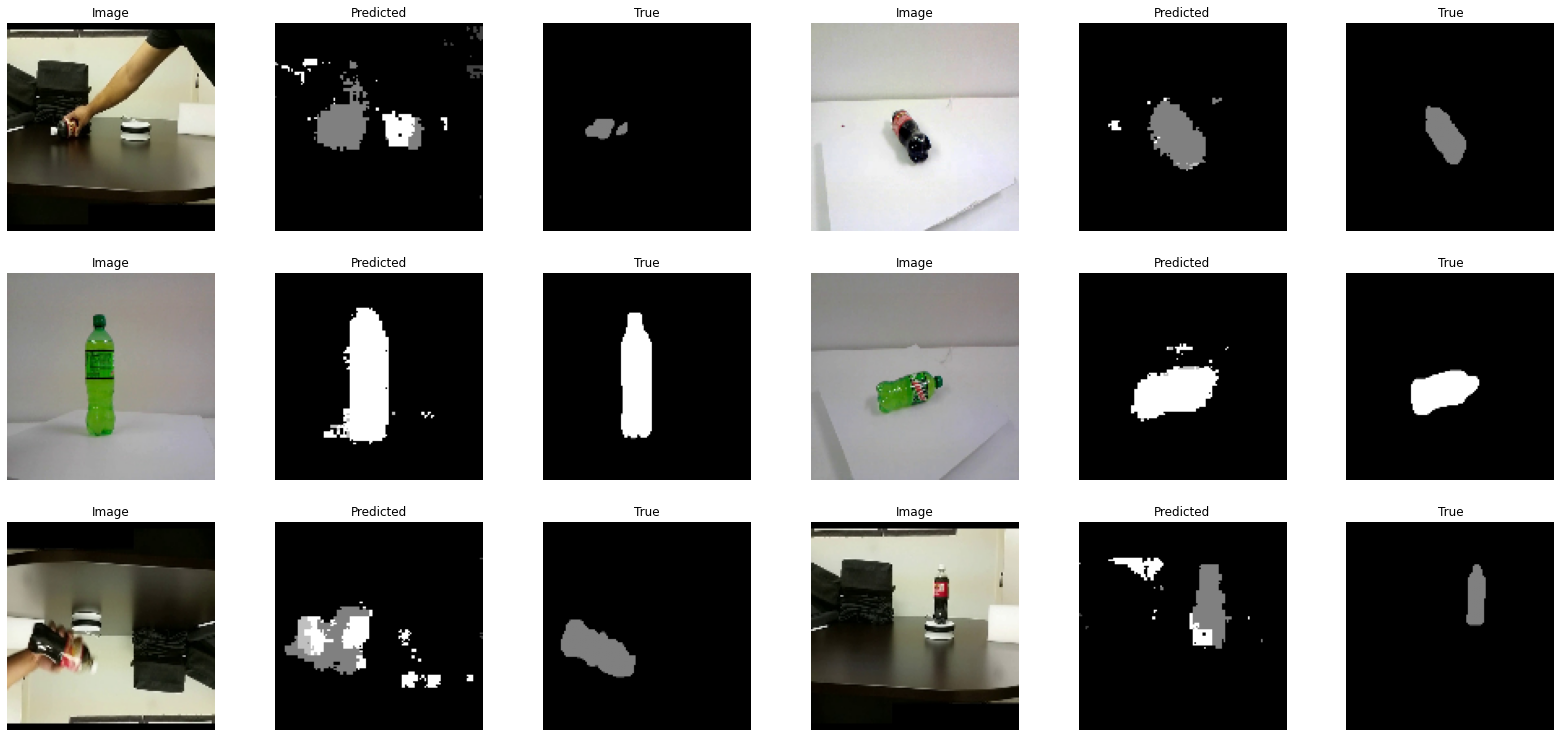

In [454]:
fig, ax = plt.subplots(3, 6, figsize=(28, 13))

for i in range(3):
  for j in range(2):
    ax[i][3*j].set_title('Image')
    ax[i][3*j+1].set_title('Predicted')
    ax[i][3*j+2].set_title('True')
    ax[i][3*j].axis('off')
    ax[i][3*j+1].axis('off')
    ax[i][3*j+2].axis('off')

for i in range(3):
  for j in range(2):
    index = np.random.randint(0, 240)
    ax[i][3*j].imshow(tf.keras.preprocessing.image.array_to_img(images[index]))
    ax[i][3*j+1].imshow(get_predicted_mask(images[index])*0.25, cmap='gray', vmin=0, vmax=1)
    ax[i][3*j+2].imshow(np.squeeze(masks[index], axis=2)*0.25, cmap='gray', vmin=0, vmax=1)
  
plt.show()